In [156]:
import numpy as np
from numpy import save
from numpy import asarray
from numpy import load
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import tensorflow as tf
import statistics 
import random
import progressbar
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, MaxPool2D, LeakyReLU


In [157]:
joint_name = ['HeadF', 'HeadB', 'HeadL', 'SpineF', 'SpineM', 'SpineL', 
            'Offset1', 'Offset2', 'HipL', 'HipR', 'ElbowL', 'ArmL', 
            'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 
            'KneeL', 'ShinL', 'ShinR']

joints_idx = [[1, 2], [2, 3], [1, 3], [2, 4], [1, 4], [3, 4], [4, 5], 
            [5, 6], [4, 7], [7, 8], [5, 8], [5, 7], [6, 8], [6, 9], 
            [6, 10], [11, 12], [4, 13], [4, 14], [11, 13], [12, 13], 
            [14, 15], [14, 16], [15, 16], [9, 18], [10, 17], [18, 19], 
            [17, 20]]
folder = 'datasets/data_5/'

In [158]:
# normalizes a matrix
def normalize(matrix):
    max_numb = max(matrix[~np.isnan(matrix)])
    norm = matrix/max_numb
    return np.array(norm)
    # return matrix

In [159]:
from scipy.spatial.distance import cdist
# Get the distance to every single point 
def getAllDistances(matFile, numb):
    mat = matFile[numb]
    mat = mat.T
    dist = cdist(mat, mat, 'euclidean')
    norm = normalize(dist)
    max_dist = max(dist.flatten())
    return norm, max_dist

In [160]:
# Get the absolute height difference to every single point 
def getAllHeights(matFile, numb):
    mat = matFile[numb]
    z = mat[2]
    reshaped = int(matFile.shape[2])
    height = []

    for i in range(reshaped):
        for j in range(reshaped):
            if np.nan in [z[i], z[j]]:
                height.append(np.nan)
            else:
                height.append(np.abs(z[i]-z[j]))

    # normalizes height data
    height = normalize(np.array(height).reshape(reshaped, reshaped))
    return height, max(height.flatten())


In [161]:
# Get the angle to every single point 
def getAllAngles(matFile, numb):
    mat = matFile[numb]
    mat = mat.T
    angle = cdist(mat, mat, 'cosine')
    return normalize(angle), max(angle.flatten())

In [162]:
def getData(data, numb): 
    cnn_inputs = []
    max_dist_list = []
    max_height_list = []
    max_angle_list = []

    bar = progressbar.ProgressBar()

    for i in bar(range(numb)):
        dist, max_dist = getAllDistances(data, i) 
        height, max_height = getAllHeights(data, i)
        angle, max_angle = getAllAngles(data, i)

        # max_dist_list.append(max_dist)
        # max_height_list.append(max_height)
        # max_angle_list.append(max_angle)

        for j in range(0, data.shape[2]):
            temp = np.array([dist[j], height[j], angle[j]])
            first = temp[:,0:3]
            second = temp[:,3:20]
            first = first [ :, first[0].argsort()]
            second = second [ :, second[0].argsort()]
            output = np.concatenate((first, second), axis =1)
            cnn_inputs.append(output)

            big = output[:,:13]
            where_are_NaNs = np.isnan(big)
            big[where_are_NaNs] = 0
            max_dist_list.append(np.max(big[0]))
            max_height_list.append(np.max(big[1]))
            max_angle_list.append(np.max(big[2]))
# median 
    avg_max_dist = statistics.median(max_dist_list)
    avg_max_height = statistics.median(max_height_list)
    avg_max_angle = statistics.median(max_angle_list)
    avg_max = [avg_max_dist, avg_max_height, avg_max_angle]

    cnn_inputs = np.array(cnn_inputs)[:,:,:13]
    final = []
    for i in range(len(cnn_inputs)):
        for j in range(3):
            final.append(cnn_inputs[i][j]/avg_max[j])
    
    cnn_inputs = np.array(final).reshape((cnn_inputs.shape[0], 39))
    where_are_NaNs = np.isnan(cnn_inputs)
    cnn_inputs[where_are_NaNs] = 0
    return cnn_inputs


In [7]:
train_file = loadmat('mat_files/bigSet1.mat')
test_file = loadmat('mat_files/bigSet2.mat')

In [ ]:
train_data = train_file['bigSet1']
test_data = test_file['bigSet2']
train_labels = train_file['labels1']
test_labels = test_file['labels2']
# set numb of data used
numb_train = len(train_data)
numb_test = 10000

# Take some frames from the list to use as trian and test data
# index_train = np.linspace(0, len(train_labels), num = numb_train, endpoint=False).astype(int)
index_test = np.linspace(0, len(test_labels), num = numb_test, endpoint=False).astype(int)
# pre_train_data = train_data[index_train]
# pre_train_labels = train_labels[index_train]
pre_train_data = train_data
pre_train_labels = train_labels
pre_test_data = test_data[index_test]
pre_test_labels = test_labels[index_test]

print("Shape of pre_train_data:", pre_train_data.shape)
print("Shape of pre_test_data:", pre_test_data.shape)
print("Shape of pre_train_labels:", pre_train_labels.shape)
print("Shape of pre_test_labels:", pre_test_labels.shape)


In [ ]:
# Get measurement data for every 3D point
train_data = getData(pre_train_data, numb_train)
test_data = getData(pre_test_data, numb_test)

# Flatten the trian labels to fit dimentions of data
train_labels = pre_train_labels.flatten()[0:(numb_train*20)]-1
test_labels = pre_test_labels.flatten()[0:(numb_test*20)]-1

print("Shape of train_data:", train_data.shape)
print("Shape of test_data:", test_data.shape)
print("Shape of train_labels:", train_labels.shape)
print("Shape of test_labels:", test_labels.shape)

In [ ]:
# Get index where the data is all 0
nans_train = np.sort(np.where(~train_data.any(axis=1))[0])[::-1]
nans_test = np.sort(np.where(~test_data.any(axis=1))[0])[::-1]

# Turn data into lists
train_data_new = list(train_data)
test_data_new = list(test_data)
train_labels_new = list(train_labels)
test_labels_new = list(test_labels)

bar = progressbar.ProgressBar()
# Remove the nan values 
for i in bar(nans_train):
    train_data_new.pop(i)
    train_labels_new.pop(i)
bar = progressbar.ProgressBar()
for i in bar(nans_test):
    test_data_new.pop(i)
    test_labels_new.pop(i)

# Turn data back into array
train_data_new = np.array(train_data_new)
train_labels_new = np.array(train_labels_new)
test_data_new = np.array(test_data_new)
test_labels_new = np.array(test_labels_new)

print("Shape of train_data_new:", train_data_new.shape)
print("Shape of test_data_new:", test_data_new.shape)
print("Shape of train_labels_new:", train_labels_new.shape)
print("Shape of test_labels_new:", test_labels_new.shape)

In [264]:
# Creates the ML training platform to predict rat joints
def ml_traning(train_data, train_labels, test_data, test_labels):
    # DIMENTION CHANGE
    train_data = train_data.reshape(train_data.shape[0], 39)
    test_data = test_data.reshape(test_data.shape[0], 39)
    # train_data = train_data.reshape(train_data.shape[0], 60)
    # test_data = test_data.reshape(test_data.shape[0], 60)
    train_data = train_data.astype('float32')
    test_data = test_data.astype('float32')

    model = createModel()
    ml_folder = os.path.join(folder,"training_2")
    if not os.path.isdir(ml_folder):
        os.mkdir(ml_folder)
    checkpoint_path = ml_folder + "/cp.ckpt"
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)

    model.fit(x=train_data,y=train_labels, verbose='auto', batch_size=20, epochs=2, validation_data=(test_data, test_labels), callbacks=[cp_callback])
    
    loss, acc = model.evaluate(test_data, test_labels, verbose=1)
    print("Loss:", loss)
    print("Accuracy:", acc*100)
    return model

# Creates the model for the CNN
def createModel():
    model = Sequential()
    model.add(Dense(640, activation= LeakyReLU()))
    model.add(Dense(320, activation= LeakyReLU()))
    # model.add(Dropout(rate=0.25))
    model.add(Dense(80, activation= LeakyReLU()))
    model.add(Dense(len(joint_name), activation = "softmax"))
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [267]:
# if not os.path.isdir(folder):
#     os.mkdir(folder)
# save(folder + 'train_data.npy', asarray(train_data_new))
# save(folder + 'train_labels.npy', asarray(train_labels_new))
# save(folder + 'test_data.npy', asarray(test_data_new))
# save(folder + 'test_labels.npy', asarray(test_labels_new))
folder = "datasets/data_2/"
train_data_new = load(folder + 'train_data.npy')
train_labels_new = load(folder + 'train_labels.npy')
test_data_new = load(folder + 'test_data.npy')
test_labels_new = load(folder + 'test_labels.npy')

In [10]:
print(test_data_new.shape, test_labels_new.shape)

(182109, 39) (182109,)


In [11]:
# skeleton_model = ml_traning(train_data_new, train_labels_new, test_data_new, test_labels_new)

In [268]:
checkpoint_path = folder + "training_2/cp.ckpt"
skeleton_model = createModel()
skeleton_model.load_weights(checkpoint_path).expect_partial()

# Re-evaluate the model
loss, acc = skeleton_model.evaluate(test_data_new, test_labels_new)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

5691/5691 [==============================] - 23s 4ms/step - loss: 0.6652 - accuracy: 0.8245
Restored model, accuracy: 82.45%


In [13]:
test_pred = np.argmax(skeleton_model.predict(test_data_new), axis=-1)
con_mat = tf.math.confusion_matrix(labels=test_labels_new, predictions=test_pred).numpy()

In [14]:
row_sums = con_mat.sum(axis=1)
new_matrix = con_mat / row_sums[:, np.newaxis]

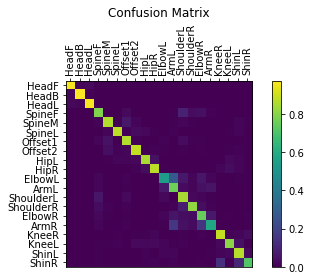

In [15]:
%matplotlib inline
# %matplotlib tk
fig, ax = plt.subplots()
ax.set_title("Confusion Matrix")
ax.set_xticks((0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19))
ax.set_xticklabels(joint_name, rotation=90)
ax.set_yticks((0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19))
ax.set_yticklabels(joint_name)
ax.xaxis.tick_top()
temp = ax.imshow(new_matrix,interpolation='nearest', aspect=1)
plt.colorbar(temp, ax=ax)
plt.tight_layout()
fig.savefig("cm.tiff")

In [16]:
# Tests individual points and tells you if the CNN worked
def handTest(image_index, test_data, label, model, maxNumb):
    max_index = len(joint_name)*maxNumb-1
    if image_index <= max_index:
        predict(test_data, image_index, label, model)
    else:
        print("ERROR: Your predict_index must be below", max_index)

# Showing individual predictions
def predict(data, image_index, label, model):
    img = [data[image_index]]
    # DIMENTION CHANGE
    img = np.array(img).reshape(3,13)
    # img = np.array(img).reshape(3,20)
    plt.imshow(img)
    plt.show()

    pred = model.predict(img.reshape(1, 39))
    # pred = model.predict(img.reshape(1, 60))
    predict = pred.argmax()
    actual = label[image_index]

    print("Actual:", actual)
    print("Predicted:", predict)
    
    if predict == actual:
        print("YAY ✿(ᵔ‿ᵔ)")
    else:
        print("Wrong (◕︵◕)")

    

In [5]:
# for i in range(420,440):
#     handTest(i, test_data, test_labels, skeleton_model, numb_test)

In [118]:
import h5py
temporal_file = h5py.File('mat_files/JDM25baseline_Ext4_timematched_controltsne_analysis_struct_mocapdata.mat', 'r') 
print(temporal_file.keys())

<KeysViewHDF5 ['alteredM', 'labelsM']>


In [119]:
temp_data = temporal_file['alteredM'][:]
temp_labels = temporal_file['labelsM'][:]

In [120]:
temporal_file.close()

In [121]:
copy_data = temp_data.copy()
copy_labels = temp_labels.copy()

In [344]:

new_temp_data = copy_data[:,:,:2000]
num_fms =  new_temp_data.shape[2]
new_temp_labels = copy_labels[:,:num_fms]
print(new_temp_data.shape, new_temp_labels.shape)
num_pts = len(new_temp_data)


(20, 3, 2000) (20, 2000)


In [345]:
%matplotlib inline
temp_pts = []
bar = progressbar.ProgressBar()
for i in bar(range(new_temp_labels.shape[1])):
    label = np.array(new_temp_labels[:,i])
    data = new_temp_data[:,:,i]
    stack = np.column_stack((data, label))
    stack = np.array(sorted(stack,key=lambda x: x[3]))
    temp_pts.append(stack[:,:3])
    # plt.imshow(stack[:,:3], interpolation='nearest', aspect="auto")
    # plt.show()  

100% (2000 of 2000) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


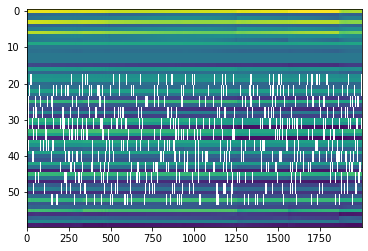

In [346]:
test_pts = np.array(temp_pts).reshape(num_fms, 3*num_pts).T
plt.imshow(test_pts, interpolation='nearest', aspect="auto")
plt.show()

In [347]:
# %matplotlib tk
# final_data = np.transpose(final_data, (0,2,1))
# print(final_data.shape)
# plotFrame(final_data[0], final_data[0], 0)

In [348]:
# import h5py
# temporal_file = h5py.File('mat_files/JDM32baseline_Ext4_timematched_controltsne_analysis_struct_mocapdata.mat', 'r') 
# print(temporal_file.keys())

In [349]:
# temp_data = temporal_file['markers'][:]

In [350]:
# temporal_file.close()

In [351]:
# print(temp_data.shape)
# print(type(temp_data))

In [352]:
# temp_data[temp_data < .1] = np.nan

In [353]:
xyz_data = temp_data.reshape(60,9040006)

In [354]:
%matplotlib inline
num_fms = 3000
num_pts = int(xyz_data.shape[0]/3) #22
# raw_pts = xyz_data
raw_pts = xyz_data[:,:num_fms]

num_fms = np.array(test_pts).shape[1]

plt.imshow(raw_pts, interpolation='nearest', aspect="auto")
plt.show()

In [355]:
# import random
# test_pts = raw_pts.copy()
# for i in range(3,num_pts):
#     times = random.randint(10,20)
#     for j in range(times):
#         length_gap = random.randint(0,100)
#         start_gap = random.randint(0,num_fms-1)
#         end_gap = start_gap + length_gap
#         test_pts[i*3][start_gap:end_gap] = np.nan
#         test_pts[i*3+1][start_gap:end_gap] = np.nan
#         test_pts[i*3+2][start_gap:end_gap] = np.nan
# plt.imshow(test_pts, interpolation='nearest', aspect="auto")
# plt.show()

In [356]:
input_pts = test_pts.reshape(num_pts, 3, num_fms).T

In [357]:
processed_time = getData(input_pts, len(input_pts))

100% (2000 of 2000) |####################| Elapsed Time: 0:00:09 Time:  0:00:09


In [358]:
process_pts = processed_time.reshape(num_fms, num_pts, 39)
temp = processed_time.reshape(num_fms, num_pts, 39)
processed = np.transpose(temp,(1, 0, 2))

In [359]:
print(processed.shape)

(60, 2000)


In [360]:
chunks = []
temp = np.ones((num_pts,num_fms))
bar = progressbar.ProgressBar()
# run through all the registered points (0,22)
for i in bar(range(num_pts)):
    # get every third row
    row = i*3
    row_list = []
    temp_list = []

    # run through length of each row (0,3000)
    for j in range(num_fms): 
        # not a nan, add index to list
        if not np.isnan(test_pts[row][j]):
            temp_list.append(j)
            temp[i][j] = temp[i][j]*2
        # if element is a nan and the current list is not empty
        elif len(temp_list) > 0:
            # add list to output and clear the list
            row_list.append([temp_list[0], temp_list[-1]])
            temp_list = []
    # edge case, add to output if the list still contains values
    if len(temp_list) > 0:
        row_list.append([temp_list[0], temp_list[-1]])
    chunks.append(row_list)

100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [361]:
# Check the chunk list
chunks = np.array(chunks, dtype=list)
for i in range(len(chunks)):
    print("Point: "+str(i) +", Chunks: " + str(len(chunks[i])))

Point: 0, Chunks: 1
Point: 1, Chunks: 1
Point: 2, Chunks: 1
Point: 3, Chunks: 1
Point: 4, Chunks: 1
Point: 5, Chunks: 1
Point: 6, Chunks: 242
Point: 7, Chunks: 266
Point: 8, Chunks: 252
Point: 9, Chunks: 234
Point: 10, Chunks: 257
Point: 11, Chunks: 263
Point: 12, Chunks: 271
Point: 13, Chunks: 255
Point: 14, Chunks: 255
Point: 15, Chunks: 241
Point: 16, Chunks: 237
Point: 17, Chunks: 285
Point: 18, Chunks: 1
Point: 19, Chunks: 1


In [362]:
temp = np.arange(20)
print(temp[5:8])

[5 6 7]


In [363]:
%matplotlib inline
from scipy import stats
temporal_data = []
# loop through all the points (0,22)
for i in range(len(chunks)):
    prediction = []
    confidence = []
    data = chunks[i] # list of chunks in a given row
    model_pred = skeleton_model.predict(processed[i])
    print("\nPoint: "+ str(i) + ", Segments: " + str(len(data)))
    for j in range(len(data)):
        seg_range = data[j] 
        lower = seg_range[0]
        upper = seg_range[1]+1
        seg_len = upper - lower
        seg = model_pred[lower:upper]
        
        # get the predictions per frame
        pred_frame = seg.argmax(axis=-1)
        # adding up all the confident scores together
        conf_sum = np.sum(seg, axis=0)/seg_len
        # get the prediction with highest confident score
        pred = conf_sum.argmax()
        # get the highest confident score 
        conf = conf_sum.max()
        # count how many times the prediction apppears per chunk 
        pred_count = np.sum(pred == pred_frame)
        # get the percent of how many times it appears 
        pred_mode = pred_count/seg_len
        # get the list of predictions in decending order 
        rank_pred = np.argsort(conf_sum.argsort())

        # print(i, ": (", j+1, "/", len(data), "):", pred ,"[", lower, ",", upper, "], (", pred_count, "/", seg_len, ") =", pred_mode, ",", conf)
        add_data = [i, rank_pred, seg_range, pred_count, seg_len, pred_mode, conf, conf_sum]
#         print(add_data)
        prediction.append(add_data)
    temporal_data.append(prediction)



Point: 0, Segments: 1

Point: 1, Segments: 1

Point: 2, Segments: 1

Point: 3, Segments: 1

Point: 4, Segments: 1

Point: 5, Segments: 1

Point: 6, Segments: 242

Point: 7, Segments: 266

Point: 8, Segments: 252

Point: 9, Segments: 234

Point: 10, Segments: 257

Point: 11, Segments: 263

Point: 12, Segments: 271

Point: 13, Segments: 255

Point: 14, Segments: 255

Point: 15, Segments: 241

Point: 16, Segments: 237

Point: 17, Segments: 285

Point: 18, Segments: 1

Point: 19, Segments: 1


In [364]:
# save(folder + 'temporal_data.npy', asarray(temporal_data, dtype=object))
# save(folder + 'confidence_levels.npy', asarray(confidence_levels, dtype=object))
# save(folder + 'predict_numbs.npy', asarray(predict_numbs, dtype=object))

# temporal_data = load(folder + 'temporal_data.npy', allow_pickle=True)

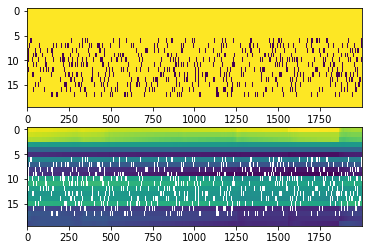

In [365]:
temp_new = np.ones((num_pts,num_fms))
for i in range(len(temporal_data)):
    for j in range(len(temporal_data[i])):
        start = temporal_data[i][j][2][0]
        end = temporal_data[i][j][2][1] + 1
        for k in range(start, end):
            temp_new[i][k] +=1
fig, (ax1, ax2) = plt.subplots(2)
ax1.imshow(temp_new, interpolation='nearest', aspect="auto")
ax2.imshow(test_pts[::3], interpolation='nearest', aspect="auto")

In [366]:
temp_copy = temporal_data.copy()
temp_data = np.array(temp_copy, dtype=object)

In [367]:
print(temp_data.shape)

(20,)


In [368]:
chunk_data = []

for i in range(20):
    chunk_data.append([])
    
# putting the preditions into buckets
for i in range(num_pts):
    index = temp_data[i]
    for j in range(len(index)):
        chunk_data[index[j][1].argmax()].append(index[j])

for i in range(len(chunk_data)):
    print(i, len(chunk_data[i]))
#     for j in range(len(chunk_data[i])):
#         print(chunk_data[i][j])

0 2
1 0
2 1
3 107
4 18
5 1
6 345
7 283
8 264
9 181
10 260
11 273
12 276
13 67
14 240
15 183
16 214
17 286
18 54
19 11


In [369]:
def squish(chunk_data):
    unprocessed_pts = []
    processed_pts = []
    # squish all the data points
    for i in range(20): 
        numb_index = []
        unprocessed = []
        bounds = None
        current = chunk_data[i]
        cert = chunk_data[i]
        sorted_current = sorted(current,key=lambda x: x[4])
        
        for j in reversed(range(len(sorted_current))):
            input_index = sorted_current[j]
            current_bounds = np.arange(input_index[2][0], input_index[2][1]+1).tolist()

            if len(numb_index) == 0:
                numb_index.append(input_index)
                bounds = current_bounds
            else:
                same = list(set(current_bounds) & set(bounds)) # gets overlapping elements 
                # no overlapp between the two lists
                if len(same) == 0:
                    numb_index.append(input_index)
                    bounds += current_bounds
                else: #if there is overlap between the two lists
                    if current_bounds[0] in bounds or current_bounds[-1] in bounds:
#                         print(str(i) + ") Can't add index in range [" + str(current_bounds[0]) + ", " + str(current_bounds[-1]) + "] to [" + str(bounds[0])+ ", " + str(bounds[-1]) + "]")
                        unprocessed.append(input_index)
                        pass
                    elif current_bounds[0] in bounds:
                        print("Lower bound inside current bounds")
                        pass
                    elif current_bounds[-1] in bounds:
                        print("Upper bound inside current bounds")
                        pass
            bounds = sorted(bounds)
        processed_pts.append(numb_index)
        unprocessed_pts.append(unprocessed)
    processed_pts = np.array(processed_pts, dtype = object)
    unprocessed_pts = np.array(unprocessed_pts, dtype = object)
    return processed_pts, unprocessed_pts
 

In [370]:
processed_pts, unprocessed_pts = squish(chunk_data)

In [371]:
# unproc_pts = np.copy(unprocessed_pts)

In [372]:
# new_conf = []
# for i in range(len(unproc_pts)):
#     if len(unproc_pts[i]) == 0:
#         new_conf.append([])
#     else:
#         temp_new_conf = []
#         for j in range(len(unproc_pts[i])):
#             conf = np.copy(unproc_pts[i][j][1])
#             max_index = conf.argmax()
#             conf[max_index] = 0
#             new_max = conf.argmax()
#             add_data = [new_max] + [conf] + unproc_pts[i][j][2:8]
#             temp_new_conf.append(add_data)
#         new_conf.append(temp_new_conf)

In [373]:
# processed_pts_2, unprocessed_pts_2 = squish(new_conf)

In [374]:
# for i in range(len(processed_pts)):
#     print("Point:", i, end = " --> ")
#     for j in range(len(processed_pts[i])):
#         print(processed_pts[i][j][0], end = ", ")
#     print("")

In [375]:
final_points = []
point_coord = np.ones((60,num_fms))*np.nan

for i in range(len(processed_pts)):
    index = [i*3, i*3+1, i*3+2]
    coord = [[],[],[]]

    for j in range(len(processed_pts[i])):
        seg_range = processed_pts[i][j]
        org_index = seg_range[0]
        start = seg_range[2][0]
        end = seg_range[2][1]
        index_xyz = [org_index*3, org_index*3+1, org_index*3+2]

        for k in range(start, end):
            point_coord[index[0]][k] = test_pts[index_xyz[0]][k]
            point_coord[index[1]][k] = test_pts[index_xyz[1]][k]
            point_coord[index[2]][k] = test_pts[index_xyz[2]][k]
            if np.isnan(test_pts[index_xyz[0]][k]):
                print("big error", seg_range)

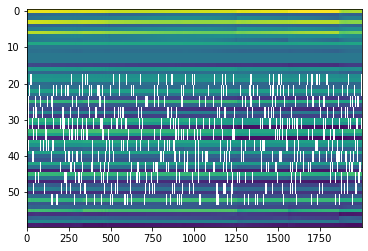

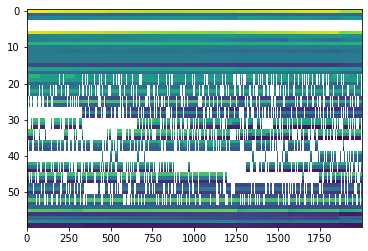

In [376]:
%matplotlib inline
plt.imshow(test_pts, interpolation='nearest', aspect="auto")
plt.show()
plt.imshow(point_coord, interpolation='nearest', aspect="auto")
plt.show()

In [377]:
# Draw major lines in the rat model
def drawLines(ax,x, y, z):
    # run through all the connections to draw the points
    for i in range(len(joints_idx)):
        try: 
            # Getting both points to draw line
            idx = joints_idx[i]
            first_pt = idx[0]-1
            second_pt = idx[1]-1
            x_line = [x[first_pt], x[second_pt]]
            y_line = [y[first_pt], y[second_pt]]
            z_line = [z[first_pt], z[second_pt]]
            # Draw lines
            if i < 3: 
                ax.plot(x_line, y_line, z_line, c="#064ea1", linewidth=4)
            elif i < 6:
                ax.plot(x_line, y_line, z_line, c="#64ccd1", linewidth=4)
            else:
                ax.plot(x_line, y_line, z_line, c="#46b8a7", linewidth=4)
        except:
            pass

# Draw all line from every point 
def drawAllLines(ax,x, y, z):
    joint_len = len(joint_name)
    all_lines = []
    for i in range(joint_len):
        for j in range(joint_len):
            if (not([i,j] in all_lines)):
                x_line = [x[i], x[j]]
                y_line = [y[i], y[j]]
                z_line = [z[i], z[j]]
                ax.plot(x_line, y_line, z_line, color='#b1d8fc', linewidth=0.5)
                all_lines.append([i,j])
                all_lines.append([j,i])

def addLabels(ax, x, y, z):
    # run through all the points to add labels
    for i in range(len(x)):
        try:
            # points_array.append([x[i], y[i], z[i]])
            # label = np.around(points_array[i]).astype(int)
            label = joint_name[i]
            if not np.isnan(x[i]):
                ax.text(x[i], y[i], z[i], label)
            # print(i, ":", points_array[i], joint_name[i])
        except:
            pass

In [378]:
# %matplotlib tk

# Plot 3D points given file and frame number
def plotFrame(pts, frame, draw):
    x = frame[0]
    y = frame[1]
    z = frame[2]
    x_pts = pts[0]
    y_pts = pts[1]
    z_pts = pts[2]

    # plt.imshow([x, y,z])
    # plt.show()

    # loading plot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # adding points, labels and lines
    try:
        ax.scatter(x,y,z, color='#ff5e5e', s =10, marker='x')
        ax.scatter(x_pts,y_pts,z_pts, color='b', s =10)
    except:
        pass
    if draw == 0:
        drawLines(ax, x, y, z)
        addLabels(ax, x, y, z)
        
    # Labeling plot
    ax.set_title("Rat positioning")
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    # rotate the axes and update
#     for angle in range(0, 90):
#         ax.view_init(30, angle)
#         plt.draw()
#         plt.pause(.001)


In [393]:
figure = point_coord.copy()[:,::10]
print(figure.shape)
# temp_2 = np.transpose(figure.T.reshape(num_fms, 20, 3), (0,2,1))
# temp_3 = test_pts.copy()
# temp_4 = np.transpose(temp_3.T.reshape(num_fms, num_pts, 3), (0,2,1))

(60, 200)


In [380]:
# %matplotlib tk
# plotFrame(temp_4[1000], temp_2[1000], 0)
# plt.show()

In [381]:
print(point_coord.shape)

(60, 2000)


In [394]:
%matplotlib tk
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib.animation import FuncAnimation

connections = [[0,1,2,0], [2,3,4,5], [3,6,7,5], [10, 11, 12, 3, 13, 14, 15], [18,17,8,5,9,16,19]]
fig = plt.figure()
ax = p3.Axes3D(fig, auto_add_to_figure=False )
fig.add_axes(ax)

def animfunc(t):
    ax.clear()
    
    lines = []
    frame = t
    for conn in connections:
        x = [3*i for i in conn]
        y = [i+1 for i in x]
        z = [i+2 for i in x]
        lines.append(ax.scatter(test_pts[x, frame], test_pts[y,frame],  test_pts[z, frame], color='r', s =10))
        lines.append(ax.scatter(figure[x, frame], figure[y,frame],  figure[z, frame], color='b', s =10))
        # lines.append(ax.plot(figure[x, frame], figure[y,frame],  figure[z, frame], linewidth=3))
    return lines,
        
anim = FuncAnimation(fig, animfunc, frames=figure.shape[1], interval=10, repeat=False)
# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)